# easyOCR을 활용한 언어경관분류

## Environment setting

In [4]:
## environment setting
import easyocr
import cv2
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import matplotlib
import PIL
from PIL import ImageFont, ImageDraw, Image
import os
import glob

## Data preprocessing

In [5]:
dir = "C:/Users/user/Desktop/easyOCR_LL/isprs20_data/zone1/"
folder_list = os.listdir(dir)
folder_list.sort()

isprs20 = []

for i in folder_list:
    file_list = dir + i + '/*.png'
    file_list = glob.glob(file_list)
    
    for j in file_list:
        split_list = j.split('-')
        zone = split_list[0][-2:]
        location = split_list[1]
        date = split_list[2] + '-' + split_list[3]
        image = cv2.imread(j)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # bbox from geometry data
        gdf = gpd.GeoDataFrame.from_file(j[:-3] + 'shp')
        
        bbox = []
        for n in range(0, len(gdf.geometry)):
            try:
                x, y = gdf.geometry[n].exterior.coords.xy
            except:
                print('멀티폴리곤 제외')
                continue
            
            for k in range(0, len(y)):
                y[k] *= -1
            xy = xy = [(x[h], y[h]) for h in range(0, len(x))]
            
            bbox.append(xy)
        
        # label
        target = gdf.iloc[:, 0].tolist()
        
        temp = {'zone':zone, 'location':location, 'date':date, 
                'image':image, 'bbox':bbox, 'target':target}
        isprs20.append(temp)

멀티폴리곤 제외
멀티폴리곤 제외


In [6]:
dir = "C:/Users/user/Desktop/easyOCR_LL/isprs20_data/zone2/"
folder_list = os.listdir(dir)
folder_list.sort()

for i in folder_list:
    file_list = dir + i + '/*.png'
    file_list = glob.glob(file_list)
    
    for j in file_list:
        split_list = j.split('-')
        zone = split_list[0][-2:]
        location = split_list[1]
        date = split_list[2] + '-' + split_list[3]
        image = cv2.imread(j)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # bbox from geometry data
        gdf = gpd.GeoDataFrame.from_file(j[:-3] + 'shp')
        
        bbox = []
        for n in range(0, len(gdf.geometry)):
            try:
                x, y = gdf.geometry[n].exterior.coords.xy
            except:
                print('멀티폴리곤 제외')
                continue
            
            for k in range(0, len(y)):
                y[k] *= -1
            xy = xy = [(x[h], y[h]) for h in range(0, len(x))]
            
            bbox.append(xy)
        
        # label
        target = gdf.iloc[:, 0].tolist()
        
        temp = {'zone':zone, 'location':location, 'date':date, 
                'image':image, 'bbox':bbox, 'target':target}
        isprs20.append(temp)

## bbox detecting accuracy

In [11]:
ocr_bbox = []

reader = easyocr.Reader(['ko', 'en'])
for data in isprs20:
  ocr_temp_two = []
  result = reader.readtext(data['image'], decoder='greedy', batch_size=16, rotation_info=[90, 180, 270],
                          slope_ths=0.25)
  
  for i in range(0, len(result)):
    ocr_temp_one = []
 
    for j in range(0, len(result[i][0])):
      ocr_temp_one.append(tuple(result[i][0][j]))
    ocr_temp_two.append(ocr_temp_one)
 
  ocr_bbox.append(ocr_temp_two)

In [12]:
## Visualize BBox

def create_bbox(img, bbox):
  temp_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(temp_pil, "RGBA")

  for coords in bbox:
    draw.polygon(coords, fill=(0, 255, 0 ,80), outline = (0, 255, 0))

  plt.figure(figsize=(10, 10))
  plt.imshow(temp_pil)
  plt.show()

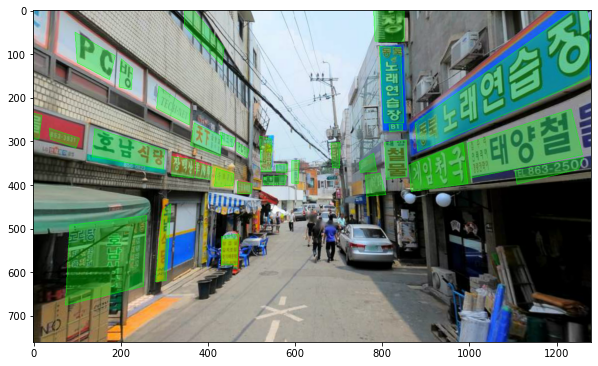

In [13]:
create_bbox(isprs20[0]['image'], isprs20[0]['bbox'])

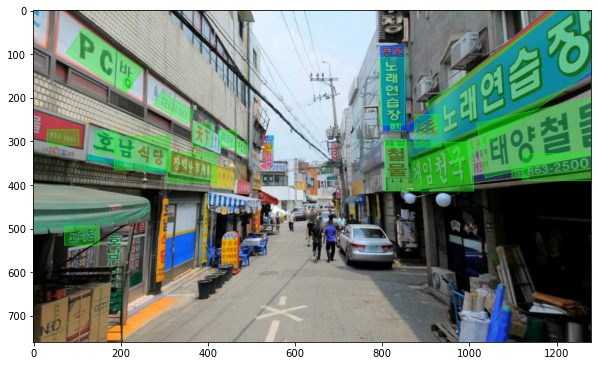

In [14]:
create_bbox(isprs20[0]['image'], ocr_bbox[0])

In [30]:
## precision metrics function
def inter_rate(gt, pred_bbox):
  # Get centroids from all bounding boxes in machine precessed image
  inter_percent = []

  for i in pred_bbox:
    centroid = np.sum(np.asarray(i), axis=0) / 4
    centroid = Point(centroid)

    for j in gt:
      gt_poly = Polygon(j)

      # If so, How much do they overlap?
      if gt_poly.contains(centroid):
        pred_poly = Polygon(i)
        try:
          intersect = pred_poly.intersection(gt_poly).area
          inter_percent.append(intersect / pred_poly.area)
        except:
          continue
  
  return(inter_percent)

def accuracy_metric(gt, pred_bbox):
  if len(gt) != 0 and len(pred_bbox) != 0:

    reliable = sum([x >= 0.8 for x in inter_rate(gt, pred_bbox)])
    acceptable = sum([x >= 0.5 for x in inter_rate(gt, pred_bbox)])
  else:
    reliable = 0
    acceptable = 0

  return reliable, acceptable

In [32]:
r_list = []
a_list = []

for x in range(0, len(isprs20)):
    r, a = accuracy_metric(isprs20[x]['bbox'], ocr_bbox[x])
    r_list.append(r)
    a_list.append(a)

n_list = []
for n in ocr_bbox:
  n_list.append(len(n))
len(n_list)

df = pd.DataFrame({"total": n_list,
              "reliable": r_list,
              "acceptable": a_list})

TopologyException: Input geom 1 is invalid: Self-intersection at 401.39567170273597 382.53287055941195
TopologyException: Input geom 1 is invalid: Self-intersection at 401.39567170273597 382.53287055941195
TopologyException: Input geom 1 is invalid: Self-intersection at 284.28270869007679 386.68409362842391
TopologyException: Input geom 1 is invalid: Self-intersection at 284.28270869007679 386.68409362842391
TopologyException: Input geom 1 is invalid: Self-intersection at 1046.1007739799575 518.64625305955167
TopologyException: Input geom 1 is invalid: Self-intersection at 1046.1007739799575 518.64625305955167
TopologyException: Input geom 1 is invalid: Self-intersection at 1248.9280328869504 515.22692965654846
TopologyException: Input geom 1 is invalid: Self-intersection at 1248.9280328869504 515.22692965654846
TopologyException: Input geom 1 is invalid: Self-intersection at 950.9092676701822 527.51794023846901
TopologyException: Input geom 1 is invalid: Self-intersection at 950.90926

In [37]:
len(isprs20)

1664

In [38]:
## reliable / acceptable average accuracy without total = 0 
r_average_accuracy = sum(df[df['total']!=0]['reliable'] / df[df['total']!=0]['total'] * 100) / len(df)
a_average_accuracy = sum(df[df['total']!=0]['acceptable'] / df[df['total']!=0]['total'] * 100) / len(df)

print('reliable accuracy : {}'.format(r_average_accuracy))
print('acceptable accuracy : {}'.format(a_average_accuracy))

reliable accuracy : 31.460584884093524
acceptable accuracy : 64.35610519576674


In [39]:
df.describe()

,total,reliable,acceptable
count,1664.000000,1664.000000,1664.000000
mean,7.168269,2.818510,5.513822
std,6.860121,3.577271,5.895853
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,5.000000,1.000000,4.000000
75%,11.000000,4.000000,8.000000
max,46.000000,24.000000,40.000000


In [40]:
df[df['total']!=0].describe()

,total,reliable,acceptable
count,1469.000000,1469.000000,1469.000000
mean,8.119809,3.192648,6.245745
std,6.751371,3.647111,5.899492
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000
50%,6.000000,2.000000,4.000000
75%,12.000000,5.000000,9.000000
max,46.000000,24.000000,40.000000


## Recognition

In [66]:
def lang_recognize(image, confidence): # confidence = [ko conf, en conf, ch_sim conf]
  lang = []

  for language in ['ko', 'en', 'ch_sim']:
    temp = []
    reader = easyocr.Reader([language])
    result = reader.readtext(image, decoder='greedy', batch_size=32, rotation_info=[90, 180, 270],
                          slope_ths=0.25)

    for i in range(0, len(result)):
      if result[i][2] >= confidence:
        temp.append(result[i][1])
    lang.append(temp)

  return lang

In [68]:
pred_lang = []
n = 1

for data in isprs20:
  pred_lang.append(lang_recognize(data['image'], 0))
  n += 1
  
  if n % 50 == 0:
    print(f'{n} complete')

50 complete
100 complete
150 complete
200 complete
250 complete
300 complete
350 complete
400 complete
450 complete
500 complete
550 complete
600 complete
650 complete
700 complete
750 complete
800 complete
850 complete
900 complete
950 complete
1000 complete
1050 complete
1100 complete
1150 complete
1200 complete
1250 complete
1300 complete
1350 complete
1400 complete
1450 complete
1500 complete
1550 complete
1600 complete
1650 complete


In [69]:
## 텍스트 전처리
def clean_punc(text):
  punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–& '
  punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", 
                 "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', 
                 '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', 
                 '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi',}
  numbers = "1234567890"

  for p in punct_mapping:
    text = text.replace(p, '')

  for p in punct: 
    text = text.replace(p, '') 

  specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
  for s in specials:
    text = text.replace(s, '')

  # 숫자도 제거
  for n in numbers:
    text = text.replace(n, '')

  return text.strip()

In [101]:
num_lang = []

for i in pred_lang:
  a = list(map(clean_punc, i[0]))
  ko = " ".join(a).split()
  b = list(map(clean_punc, i[1]))
  en = " ".join(b).split()
  c = list(map(clean_punc, i[2]))
  ch = " ".join(c).split()

  num_lang.append([len(ko), len(en), len(ch)])
  
num_lang[0:5]

[[14, 3, 9], [14, 4, 8], [16, 2, 14], [16, 2, 15], [6, 1, 6]]

In [102]:
# ratio in linguistic landscape
for i in range(0, len(num_lang)):
  if sum(num_lang[i]) != 0:
    num_lang[i] = list(map(lambda x:round(x / sum(num_lang[i]), 4), num_lang[i]))
    
num_lang[0:5]

[[0.5385, 0.1154, 0.3462],
 [0.5385, 0.1538, 0.3077],
 [0.5, 0.0625, 0.4375],
 [0.4848, 0.0606, 0.4545],
 [0.4615, 0.0769, 0.4615]]

In [103]:
target = []

for data in isprs20:
    target.append(data['target'])

target_count = []

for t in target:
  kr_count = t.count('1')
  en_count = t.count('2')
  ch_count = t.count('3')
  
  target_count.append([kr_count, en_count, ch_count])
  
target_count[0:5]

[[21, 5, 4], [18, 2, 5], [20, 2, 6], [19, 1, 4], [18, 2, 0]]

In [104]:
for i in range(0, len(target_count)):
  if sum(target_count[i]) != 0:
    target_count[i] = list(map(lambda x:round(x / sum(target_count[i]), 4), target_count[i]))
  if sum(target_count[i]) == 0:
    target_count[i] = [0, 0, 0]

target_count = np.array(target_count)

target_count[0:5]

array([[0.7   , 0.1667, 0.1333],
       [0.72  , 0.08  , 0.2   ],
       [0.7143, 0.0714, 0.2143],
       [0.7917, 0.0417, 0.1667],
       [0.9   , 0.1   , 0.    ]])

In [105]:
# RMSE
pow(sum(pow(num_lang - target_count[5], 2)) / len(num_lang), 1/2)

array([0.42213543, 0.16331345, 0.30065998])

In [113]:
pow(sum(pow(num_lang - target_count, 2)) / len(num_lang), 1/2)

array([0.50995767, 0.2037481 , 0.31904132])